In [1]:
import pymongo
from pymongo import MongoClient
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import preprocessing
import warnings
from nbi1 import *

warnings.filterwarnings('ignore')

## Importing data

In [2]:
### Importing NBI Data
survey_records = pd.concat([pd.read_csv('ConditionRatings-first-twenty-allyears.csv'),pd.read_csv('ConditionRatings-last-thirty-allyears.csv')])

### Importing Precipitation Data
df_precp = pd.read_csv('new_climate_data.csv')

### Data Manipulation 
df_precp.drop('Unnamed: 0', axis = 1, inplace = True)

survey_records['FIPS'] = correctFips(survey_records['stateCode'], survey_records['countyCode']) ## fips need to bee int

survey_records['County '] = survey_records['FIPS'].map(getDict(df_precp['FIPS'], df_precp['County']))

survey_records['Avg. Daily Precipitation (mm)'] = survey_records['FIPS'].map(getDict(df_precp['County Code'], df_precp['Avg Daily Precipitation (mm)']))

## Data Cleaning and Preparation 

In [4]:
## Create timeseries of every bridge from the NBI dataset.
survey_timeseries = createTimeseries(survey_records)

## Identify rebuild of the bridges in timeseries and split survey records accordingly.
survey_timeseries = splitSurveyRecords(survey_timeseries)

## Identify inconsistency in aging of the bridges.
split_profiles = createSplitProfiles(survey_timeseries)

## Split bridge records again, where the inconsistencies are identified.
survey_timeseries = splitBackward(survey_timeseries, split_profiles) 

## Counting and renaming the splits of the bridges.
survey_timeseries_split_structureNumbers = splitStructureNumbers(survey_timeseries)

## Combining the all splits of the survey records 
survey_timeseries = combinedStructureNumberWithRecords(survey_timeseries_split_structureNumbers, survey_timeseries)

## Introducing each split of the bridge as a separate bridge.
survey_timeseries = createIndividualRecords(survey_timeseries)

### Creating Dataframe

In [5]:
### Creating Dataframe from 2x9 list of "survey_timeseries".
survey_timeseries_df = pd.DataFrame(survey_timeseries,  columns=['Structure Number', 'Age', 'ADT Type', 'Superstructure','Avg. Daily Precipitation', 'State Code','Average Daily Traffic','Owner'])

### flattening columns
survey_timeseries_df['State Code'] = [str(statecode[0]) for statecode in survey_timeseries_df['State Code']]
survey_timeseries_df['Average ADT'] = [np.mean(ADT) for ADT in survey_timeseries_df['Average Daily Traffic']]
survey_timeseries_df['Avg. Daily Precipitation'] = [ precp[0] for precp in survey_timeseries_df['Avg. Daily Precipitation']]
survey_timeseries_df['ADT Category'] = [ ADT_type[0] for ADT_type in survey_timeseries_df['ADT Type']]
survey_timeseries_df['Owner'] = [ ADT_type[0] for ADT_type in survey_timeseries_df['Owner']]

### shape of the dataframe
print("Shape of the dataframe: ",survey_timeseries_df.shape)

##E Printing sample of the dataframe.
survey_timeseries_df.head()

Shape of the dataframe:  (921676, 10)


,Structure Number,Age,ADT Type,Superstructure,Avg. Daily Precipitation,State Code,Average Daily Traffic,Owner,Average ADT,ADT Category
0,10000000000_1,[62],[Light],[5],2.31,40,[100],2,100.0,Light
1,20000000000_1,[94],[Light],[8],3.12,40,[150],4,150.0,Light
2,40000000000_1,[5],[Light],[8],1.87,40,[100],2,100.0,Light
3,50000000000_1,[4],[Light],[8],2.59,40,[100],2,100.0,Light
4,60000000000_1,[94],[Light],[5],3.57,40,[100],2,100.0,Light


## Computing Scores

### Computing Deterioration Scores

In [6]:
## Creating a flatlist of the Age
age_flat_list = survey_timeseries_df['Age'].tolist() ## This list - >

## Creating a flatlist of the Condition Ratings: Superstructure
superstructure_flat_list = survey_timeseries_df['Superstructure'].tolist() ## This list ->

## Computing Slope 
slopes = computeSlope(age_flat_list,superstructure_flat_list)

## Creating a new column (Deterioration Score) in the dataframe.
survey_timeseries_df['Deterioration Score'] = slopes

### Computing Baseline Difference Scores

In [7]:
## Creating the list of averages 
list_of_avgs, dict_of_avgs, counts_of_aba = getListOfAvgs(age_flat_list, superstructure_flat_list)

## Computing Baseline Difference Score
baselineScoreList = computeBaselineScore(age_flat_list, superstructure_flat_list, dict_of_avgs)

## Creating a new column (Baseline Difference Score) in the dataframe.
survey_timeseries_df['Baseline Difference Score'] = [np.mean(score) for score in baselineScoreList]

## Post Computation Data Cleaning

### Removing Outliers

In [9]:
### Removing Null Values
survey_timeseries_df = survey_timeseries_df.dropna()

### Scaling Baseline Difference Score
survey_timeseries_df['Scaled Baseline Difference Score'] =  preprocessing.scale(survey_timeseries_df['Baseline Difference Score'])

### Removing Outliers
Q1 = survey_timeseries_df['Baseline Difference Score'].quantile(0.25)
Q3 = survey_timeseries_df['Baseline Difference Score'].quantile(0.75)
IQR = Q3 - Q1
print("IQR - West Regions:",IQR)
print("Shape before removing outliers  - US Regions:",survey_timeseries_df.shape)
survey_timeseries_no_outliers_df = survey_timeseries_df[survey_timeseries_df['Baseline Difference Score'] < (Q3+1.5*IQR)]
survey_timeseries_no_outliers_df = survey_timeseries_no_outliers_df[survey_timeseries_no_outliers_df['Baseline Difference Score'] > (Q1-1.5*IQR)]
print("Shape after removing outliers  - US Regions:",survey_timeseries_no_outliers_df.shape)

IQR - West Regions: 1.2410418510116243
Shape before removing outliers  - US Regions: (886503, 13)
Shape after removing outliers  - US Regions: (855472, 13)


## Visualization

### Distribution of Baseline Difference Scores

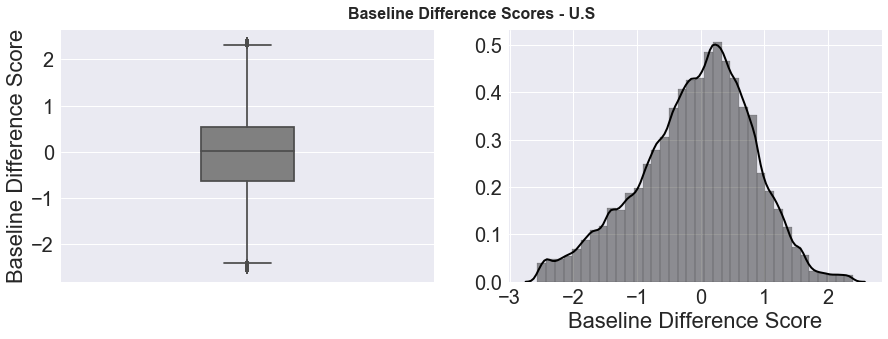

In [10]:
### Plotting Baseline Difference Scores
plt.figure(figsize=(12,4))
plt.subplots_adjust(bottom=0.025, left=0.025, top = 0.9, right=0.975)
plt.suptitle("Baseline Difference Scores - U.S", fontsize = 16,fontweight = 'bold')
sns.set(font_scale=2)
plt.subplot(1,2,1)
ax_1 = sns.boxplot(x = survey_timeseries_no_outliers_df["Baseline Difference Score"], color = 'grey', orient='v', width=.25)


plt.subplot(1,2,2)
sns.distplot(survey_timeseries_no_outliers_df['Baseline Difference Score'], hist=True, kde=True, 
             bins=int(180/5), color = 'Black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, label="US")
plt.show()

## Export data

### Without Outliers

In [12]:
survey_timeseries_no_outliers_df.to_csv("02-20-19-thesis-dataset-without-outliers")

### Without Outliers

In [11]:
survey_timeseries_df.to_csv("02-20-19-thesis-dataset")